In [1]:
import sys
sys.path.append('/home/potzschf/repos/')
from helperToolz.helpsters import *
from helperToolz.dicts_and_lists import *
from helperToolz.guzinski import * 
from helperToolz.mirmazloumi import *
from other_repos.pyTSEB.pyTSEB import meteo_utils as met
from other_repos.pyTSEB.pyTSEB import resistances as res
from other_repos.pyTSEB.pyTSEB import net_radiation as rad
from other_repos.pyTSEB.pyTSEB import clumping_index as CI
from other_repos.pyTSEB.pyTSEB import MO_similarity as MO
from other_repos.pyTSEB.pyTSEB import wind_profile as wnd
sys.path.append('/home/potzschf/.vscode-server/extensions/ms-python.vscode-pylance-2025.8.2/dist/typeshed-fallback/stdlib/')

from collections import * 
import time

In [2]:
# Threshold for relative change in Monin-Obukhov lengh to stop the iterations
L_thres = 0.001
# kB coefficient
KB_1_DEFAULT = 0.0
ITERATIONS = 15
U_FRICTION_MIN = 0.01
F_ALL_FLUXES = 0  # All fluxes produced with no reduction of PT parameter (i.e. positive soil evaporation)
F_ZERO_LE_C = 1  # Negative canopy latent heat flux, forced to zero
F_ZERO_H_C = 2  # Negative canopy sensible heat flux, forced to zero
F_ZERO_LE_S = 3  # Negative soil evaporation, forced to zero (the PT parameter is reduced in TSEB-PT and DTD)
F_ZERO_H_S = 4  # Negative soil sensible heat flux, forced to zero
F_ZERO_LE = 5  # No positive latent fluxes found, G recomputed to close the energy balance (G=Rn-H)
F_ALL_FLUXES_OS = 10  # All positive fluxes for soil only, produced using one-source energy balance (OSEB) model.
F_ZERO_LE_OS = 15  # No positive latent fluxes found using OSEB, G recomputed to close the energy balance (G=Rn-H)
F_INVALID = 255  # Arithmetic error. BAD data, it should be discarded

# mimimun allowed friction velocity
U_FRICTION_MIN = 0.01
U_S_MIN = 0.01
U_C_MIN = 0.01
R_A_MIN = 1e-1
R_A_MAX = None
RES_MIN = 1e-1
RES_MAX = None

# Maximum number of interations
ITERATIONS = 15
# kB coefficient
KB_1_DEFAULT = 0.0
# Stephan Boltzmann constant (W m-2 K-4)
SB = 5.670373e-8

# Resistance formulation constants
KUSTAS_NORMAN_1999 = 0
CHOUDHURY_MONTEITH_1988 = 1
MCNAUGHTON_VANDERHURK = 2
CHOUDHURY_MONTEITH_ALPHA_1988 = 3
HADHIGHI_AND_OR_2015 = 4

# Soil heat flux formulation constants
G_CONSTANT = 0
G_RATIO = 1
G_TIME_DIFF = 2
G_TIME_DIFF_SIGMOID = 3
emis_C = 0.98
emis_S = 0.95
z_u = 100
z_T = 100

In [3]:
def _check_default_parameter_size(parameter, input_array):

    parameter = np.asarray(parameter, dtype=np.float32)
    if parameter.size == 1:
        parameter = np.ones(input_array.shape) * parameter
        return np.asarray(parameter, dtype=np.float32)
    elif parameter.shape != input_array.shape:
        raise ValueError(
            'dimension mismatch between parameter array and input array with shapes %s and %s' %
            (parameter.shape, input_array.shape))
    else:
        return np.asarray(parameter, dtype=np.float32)

def calc_F_theta_campbell(theta, F, w_C=1, Omega0=1, x_LAD=1):
    '''Calculates the fraction of vegetatinon observed at an angle.

    Parameters
    ----------
    theta : float
        Angle of incidence (degrees).
    F : float
        Real Leaf (Plant) Area Index.
    w_C : float
        Canopy width to height ratio, optional (default = 1).
    Omega0 : float
        Clumping index at nadir, optional (default =1).
    x_LAD : float
        Chi parameter for the ellipsoidal Leaf Angle Distribution function,
        use x_LAD=1 for a spherical LAD.

    Returns
    -------
    f_theta : float
        fraction of vegetation obsserved at an angle.

    References
    ----------
    .. [Campbell1998] Campbell, G. S. & Norman, J. M. (1998), An introduction to environmental
        biophysics. Springer, New York
        https://archive.org/details/AnIntroductionToEnvironmentalBiophysics.
    .. [Norman1995] J.M. Norman, W.P. Kustas, K.S. Humes, Source approach for estimating
        soil and vegetation energy fluxes in observations of directional radiometric
        surface temperature, Agricultural and Forest Meteorology, Volume 77, Issues 3-4,
        Pages 263-293, http://dx.doi.org/10.1016/0168-1923(95)02265-Y.
    '''
    # Convert from canopy width/height to height/width as required by Kustas' Omega function
    w_C = 1. / w_C
    # First calcualte the angular clumping factor Omega based on eq (3) from
    # W.P. Kustas, J.M. Norman,  Agricultural and Forest Meteorology 94 (1999)
    # CHECK: should theta here be in degrees or radians
    OmegaTheta = (Omega0 / (Omega0 + (1.0 - Omega0)
                  * np.exp(-2.2 * np.radians(theta)**(3.8 - 0.46 * w_C))))
    # Estimate the beam extinction coefficient based on a elipsoidal LAD function
    # Eq. 15.4 of Campbell and Norman (1998)
    K_be = rad.calc_K_be_Campbell(theta, x_LAD)
    ftheta = 1.0 - np.exp(-K_be * OmegaTheta * F)
    return np.asarray(ftheta, dtype=np.float32)

def calc_T_S(T_R, T_C, f_theta):
    '''Estimates soil temperature from the directional LST.

    Parameters
    ----------
    T_R : float
        Directional Radiometric Temperature (K).
    T_C : float
        Canopy Temperature (K).
    f_theta : float
        Fraction of vegetation observed.

    Returns
    -------
    flag : float
        Error flag if inversion not possible (255).
    T_S: float
        Soil temperature (K).

    References
    ----------
    Eq. 1 in [Norman1995]_'''

    # Convert the input scalars to numpy arrays
    T_R, T_C, f_theta = map(np.asarray, (T_R, T_C, f_theta))
    T_temp = T_R**4 - f_theta * T_C**4
    T_S = np.zeros(T_R.shape, np.float32)
    flag = np.zeros(T_R.shape, np.int32) + F_ALL_FLUXES

    # Succesfull inversion
    T_S[T_temp >= 0] = (T_temp[T_temp >= 0]
                        / (1.0 - f_theta[T_temp >= 0]))**0.25

    # Unsuccesfull inversion
    T_S[np.logical_or(T_temp < 0, np.isnan(T_temp))] = 1e-6
    flag[np.logical_or(T_temp < 0, np.isnan(T_temp))] = F_INVALID

    return np.asarray(flag, dtype=np.int32), np.asarray(T_S, dtype=np.float32)

def calc_resistances(res_form, res_types):
    '''Calculate the aerodynamic resistances: R_A, R_x and R_S.

    Parameters
    ----------
    res_form : int
        Constant specifying which resistance formulation to use:
        KUSTAS_NORMAN_1999 (0), CHOUDHURY_MONTEITH_1988 (1),
        MCNAUGHTON_VANDERHURK (2), CHOUDHURY_MONTEITH_ALPHA_1988(3)
        If the constant is not any of the above then KUSTAS_NORMAN_1999 is
        used.
    res_types : Dictionary of dictionaries
        Dictionary specifying which of the three resistances to calculate. For
        each resistance to calculate the dictionary must contain a key-value
        pair with the key being the name of the resistance and value being
        another dictionary with all the parameters required to calculate the
        given resistance.
        Key: R_A
        R_A Parameters: 'z_T', 'u_friction', 'L', 'd_0', 'z_0H'
        Key: R_x
        R_x Parameters: 'u_friction', 'h_C', 'd_0', 'z_0M', 'L', 'F', 'LAI',
                        'leaf_width', 'res_params'
        Key: R_S
        R_S Parameters: 'u_friction', 'h_C', 'd_0', 'z_0M', 'L', 'omega0', 'F',
                        'leaf_width', 'z0_soil', 'z_u', 'deltaT', 'res_params'

    Returns
    -------
    R_A: float array or None
        Aerodyamic resistance to heat transport in the surface layer (s m-1)
    R_x : float array or None
        Aerodynamic resistance at the canopy boundary layer (s m-1)
    R_S: float array or None
        Aerodynamic resistance at the  soil boundary layer (s m-1)

    '''

    R_A = 0
    R_x = 0
    R_S = 0
    u_C = None

    if res_form not in [KUSTAS_NORMAN_1999, CHOUDHURY_MONTEITH_1988,
                        MCNAUGHTON_VANDERHURK, CHOUDHURY_MONTEITH_ALPHA_1988,
                        HADHIGHI_AND_OR_2015]:
        res_form = KUSTAS_NORMAN_1999

    # Determine which resistances to calculate and get the required parameters
    if 'R_A' in res_types.keys():
        z_T, u_friction, L, d_0, z_0H = [res_types['R_A'].get(k)
                                         for k in ['z_T',
                                                   'u_friction',
                                                   'L',
                                                   'd_0',
                                                   'z_0H']]
        del res_types['R_A']
        calc_R_A = True
    else:
        calc_R_A = False
    if 'R_x' in res_types.keys():
        u_friction, h_C, d_0, z_0M, L, F, LAI, leaf_width, z0_soil, massman_profile, res_params = \
            [res_types['R_x'].get(k) for k in ['u_friction', 'h_C', 'd_0', 'z_0M',
                                               'L', 'F', 'LAI', 'leaf_width',
                                               'z0_soil', 'massman_profile',
                                               'res_params']]

        del res_types['R_x']
        calc_R_x = True
    else:
        calc_R_x = False
    if 'R_S' in res_types.keys():
        u_friction, h_C, d_0, z_0M, L, omega0, F, leaf_width, z0_soil, z_u, deltaT, u, rho,\
         c_p, f_cover, w_C, res_params, LAI, massman_profile = \
             [res_types['R_S'].get(k) for k in ['u_friction', 'h_C', 'd_0', 'z_0M',
                                                'L', 'omega0', 'F', 'leaf_width',
                                                'z0_soil', 'z_u', 'deltaT',
                                                'u', 'rho', 'c_p', 'f_cover',
                                                'w_C', 'res_params', "LAI",
                                                "massman_profile"]]

        del res_types['R_S']
        calc_R_S = True
    else:
        calc_R_S = False

    # Calculate the aerodynamic resistance
    if calc_R_A:
        R_A = res.calc_R_A(z_T, u_friction, L, d_0, z_0H)
        del z_T, z_0H

    # Calculate soil and canopy resistances
    if res_form == KUSTAS_NORMAN_1999:
        if calc_R_x:
            u_C = wnd.calc_u_C_star(u_friction, h_C, d_0, z_0M, L)
            u_C = np.maximum(u_C, U_C_MIN)
            # Wind speed is highly attenuated within the canopy volume
            if massman_profile[0] <= 0:
                u_d_zm = wnd.calc_u_Goudriaan(u_C, h_C, F, leaf_width, d_0+z_0M)
            else:
                u_d_zm = wnd.calc_u_Massman(u_C, h_C, F, d_0+z_0M,
                                            massman_profile[1],
                                            xi_soil=z0_soil/h_C,
                                            c_d=massman_profile[0])

            u_d_zm = np.maximum(u_d_zm, U_C_MIN)
            # Vegetation in series with soil, i.e. well mixed, so we use
            # the landscape LAI
            R_x = res.calc_R_x_Norman(LAI, leaf_width, u_d_zm, res_params)
            del u_d_zm
        if calc_R_S:
            if u_C is None:
                u_C = wnd.calc_u_C_star(u_friction, h_C, d_0, z_0M, L)
                u_C = np.maximum(u_C, U_C_MIN)
            # Clumped vegetation enhanced wind speed for the soil surface
            if massman_profile[0] <= 0:
                u_S = wnd.calc_u_Goudriaan(u_C, h_C, LAI, leaf_width, z0_soil)
            else:
                u_S = wnd.calc_u_Massman(u_C, h_C, LAI, z0_soil,
                                         massman_profile[1],
                                         xi_soil=z0_soil/h_C,
                                         c_d=massman_profile[0])
            u_S = np.maximum(u_S, U_S_MIN)
            R_S = res.calc_R_S_Kustas(u_S, deltaT, params=res_params)

    elif res_form == CHOUDHURY_MONTEITH_1988:
        if calc_R_x:
            u_C = wnd.calc_u_C_star(u_friction, h_C, d_0, z_0M, L)
            u_C = np.maximum(u_C, U_C_MIN)
            # Vegetation in series with soil, i.e. well mixed, so we use
            # the landscape LAI
            R_x = res.calc_R_x_Choudhury(u_C, LAI, leaf_width)
            del LAI, leaf_width
        if calc_R_S:
            R_S = res.calc_R_S_Choudhury(u_friction, h_C, z_0M, d_0, z_u, z0_soil)

    elif res_form == MCNAUGHTON_VANDERHURK:
        if calc_R_x:
            # Vegetation in series with soil, i.e. well mixed, so we use
            # the landscape LAI
            R_x = res.calc_R_x_McNaughton(LAI, leaf_width, u_friction)
            del LAI, leaf_width
        if calc_R_S:
            R_S = res.calc_R_S_McNaughton(u_friction)

    elif res_form == CHOUDHURY_MONTEITH_ALPHA_1988:
        if calc_R_x:
            u_C = wnd.calc_u_C_star(u_friction, h_C, d_0, z_0M, L)
            u_C = np.maximum(u_C, U_C_MIN)
            # Wind speed is highly attenuated within the canopy volume
            alpha_prime = wnd.calc_A_Goudriaan(h_C, LAI, leaf_width)
            # Vegetation in series with soil, i.e. well mixed, so we use
            # the landscape LAI
            R_x = res.calc_R_x_Choudhury(u_C, LAI, leaf_width, alpha_prime=alpha_prime)
            del LAI, alpha_prime

        if calc_R_S:
            # Clumped vegetation enhanced wind speed for the soil surface
            alpha_k = wnd.calc_A_Goudriaan(h_C, LAI, leaf_width)
            R_S = res.calc_R_S_Choudhury(u_friction, h_C, z_0M, d_0, z_u, z0_soil, alpha_k=alpha_k)

    elif res_form == HADHIGHI_AND_OR_2015:
        if calc_R_x:
            u_C = wnd.calc_u_C_star(u_friction, h_C, d_0, z_0M, L)
            u_C = np.maximum(u_C, U_C_MIN)
            # Wind speed is highly attenuated within the canopy volume
            if massman_profile[0] <= 0:
                u_d_zm = wnd.calc_u_Goudriaan(u_C, h_C, F, leaf_width, d_0+z_0M)
            else:
                u_d_zm = wnd.calc_u_Massman(u_C, h_C, F, d_0+z_0M,
                                            massman_profile[1],
                                            xi_soil=z0_soil/h_C,
                                            c_d=massman_profile[0])

            u_d_zm = np.maximum(u_d_zm, U_C_MIN)
            # Vegetation in series with soil, i.e. well mixed, so we use
            # the landscape LAI
            R_x = res.calc_R_x_Norman(LAI, leaf_width, u_d_zm, res_params)
            del LAI, leaf_width, u_d_zm
        if calc_R_S:
            # Wind speed is highly attenuated within the canopy volume
            if massman_profile[0] <= 0:
                u_star_soil = None
            else:
                u_star_ratio_2 = wnd.calc_ustar_massman(h_C, F, z0_soil,
                                                      massman_profile[1],
                                                      Xi_soil=z0_soil/h_C,
                                                      C_d=massman_profile[0])

                u_star_soil = u_friction * np.sqrt(u_star_ratio_2)


            R_S = res.calc_R_S_Haghighi(u, h_C, z_u, rho, c_p,
                                        z0_soil=z0_soil,
                                        f_cover=f_cover,
                                        w_C=w_C)

    R_A = np.asarray(np.clip(R_A, R_A_MIN, R_A_MAX))
    R_x = np.asarray(np.clip(R_x, RES_MIN, RES_MAX))
    R_S = np.asarray(np.clip(R_S, RES_MIN, RES_MAX))

    return R_A, R_x, R_S


def calc_H_C_PT(delta_R_ni, f_g, T_A_K, P, c_p, alpha):
    '''Calculates canopy sensible heat flux based on the Priestley and Taylor formula.

    Parameters
    ----------
    delta_R_ni : float
        net radiation divergence of the vegetative canopy (W m-2).
    f_g : float
        fraction of vegetative canopy that is green.
    T_A_K : float
        air temperature (Kelvin).
    P : float
        air pressure (mb).
    c_p : float
        heat capacity of moist air (J kg-1 K-1).
    alpha : float
        the Priestley Taylor parameter.

    Returns
    -------
    H_C : float
        Canopy sensible heat flux (W m-2).

    References
    ----------
    Equation 14 in [Norman1995]_
    '''

    # slope of the saturation pressure curve (kPa./deg C)
    s = met.calc_delta_vapor_pressure(T_A_K)
    s = s * 10  # to mb
    # latent heat of vaporisation (J./kg)
    Lambda = met.calc_lambda(T_A_K)
    # psychrometric constant (mb C-1)
    gama = met.calc_psicr(c_p, P, Lambda)
    s_gama = s / (s + gama)
    H_C = delta_R_ni * (1.0 - alpha * f_g * s_gama)
    return np.asarray(H_C, dtype=np.float32)


def calc_G(calcG_params, Rn_S, i=None):

    if i is None:
        i = np.ones(Rn_S.shape, dtype=bool)
    if calcG_params[0][0] == G_CONSTANT:
        G = calcG_params[1][i]
    elif calcG_params[0][0] == G_RATIO:
        G = calc_G_ratio(Rn_S[i], calcG_params[1][i])
    elif calcG_params[0][0] == G_TIME_DIFF:
        G = calc_G_time_diff(Rn_S[i],
                             [calcG_params[1][i], calcG_params[0][1],
                              calcG_params[0][2], calcG_params[0][3]])
    elif calcG_params[0][0] == G_TIME_DIFF_SIGMOID:
        G = calc_G_time_diff_sigmoid(Rn_S[i], [calcG_params[1][i], calcG_params[0][1],
                                     calcG_params[0][2], calcG_params[0][3], calcG_params[0][4],
                                     calcG_params[0][5], calcG_params[0][6]])

    return np.asarray(G)


def monin_obukhov_convergence(l_mo, l_queue, l_converged, flag):
    l_new = np.array(l_mo)
    l_new[l_new == 0] = 1e-36
    l_queue.appendleft(l_new)
    i = np.logical_and(~l_converged, flag != F_INVALID)
    if np.sum(i) <= 1 or np.size(i) == 0:
        return i, l_queue, l_converged, np.inf


    if len(l_queue) >= 4:
        i = np.logical_and(~l_converged, flag != F_INVALID)
        if np.any(i):
            l_converged[i] = np.logical_and(
                _L_diff(l_queue[0][i], l_queue[2][i]) < L_thres,
                _L_diff(l_queue[1][i], l_queue[3][i]) < L_thres)

    if len(l_queue) == 6:
        i = np.logical_and(~l_converged, flag != F_INVALID)
        if np.any(i):
            l_converged[i] = np.logical_and.reduce(
                (_L_diff(l_queue[0][i], l_queue[3][i]) < L_thres,
                 _L_diff(l_queue[1][i], l_queue[4][i]) < L_thres,
                 _L_diff(l_queue[2][i], l_queue[5][i]) < L_thres))

    if np.sum(i) == 0 or np.size(i) == 0:
        return i, l_queue, l_converged, np.inf

    l_diff_max = np.nanmax(_L_diff(l_queue[0][i], l_queue[1][i]))
    
    return i, l_queue, l_converged, l_diff_max


def calc_G_time_diff(R_n, G_param=[12.0, 0.35, 3.0, 24.0]):
    ''' Estimates Soil Heat Flux as function of time and net radiation.

    Parameters
    ----------
    R_n : float
        Net radiation (W m-2).
    G_param : tuple(float,float,float,float)
        tuple with parameters required (time, Amplitude,phase_shift,shape).

            time: float
                time of interest (decimal hours).
            Amplitude : float
                maximum value of G/Rn, amplitude, default=0.35.
            phase_shift : float
                shift of peak G relative to solar noon (default 3hrs before noon).
            shape : float
                shape of G/Rn, default 24 hrs.

    Returns
    -------
    G : float
        Soil heat flux (W m-2).

    References
    ----------
    .. [Santanello2003] Joseph A. Santanello Jr. and Mark A. Friedl, 2003: Diurnal Covariation in
        Soil Heat Flux and Net Radiation. J. Appl. Meteor., 42, 851-862,
        http://dx.doi.org/10.1175/1520-0450(2003)042<0851:DCISHF>2.0.CO;2.'''

    # Get parameters
    time = G_param[0] - 12.0
    A = G_param[1]
    phase_shift = G_param[2]
    B = G_param[3]
    G_ratio = A * np.cos(2.0 * np.pi * (time + phase_shift) / B)
    G = R_n * G_ratio
    return np.asarray(G, dtype=np.float32)


def calc_G_time_diff_sigmoid(R_n, G_param=[12, 0, 0.35, 10.0, 14.0, 1.0, 1.0]):
    ''' Estimates Soil Heat Flux as function of time and net radiation using an asymmetric sigmoid
    function

    Parameters
    ----------
    R_n : float
        Net radiation (W m-2).
    G_param : tuple(float,float,float,float)
        tuple with parameters required (time, Amplitude,phase_shift,shape).

            time: float
                time of interest (decimal hours).
            Amplitude : float
                maximum value of G/Rn, amplitude, default=0.35.
            phase_shift : float
                shift of peak G relative to solar noon (default 3hrs after noon).
            shape : float
                shape of G/Rn, default 24 hrs.

    Returns
    -------
    G : float
        Soil heat flux (W m-2).

    References
    ----------
    .. [Santanello2003] Joseph A. Santanello Jr. and Mark A. Friedl, 2003: Diurnal Covariation in
        Soil Heat Flux and Net Radiation. J. Appl. Meteor., 42, 851-862,
        http://dx.doi.org/10.1175/1520-0450(2003)042<0851:DCISHF>2.0.CO;2.'''

    # Get parameters
    time, G_ratio_min, G_ratio_max, phase_shift_0, phase_shift_1, shape_0, shape_1 = G_param
    G_ratio = (G_ratio_min + (G_ratio_max - G_ratio_min)
               * 0.5 * (np.tanh((time - phase_shift_0) / shape_0)
               - np.tanh((time - phase_shift_1) / shape_1)))
    G = R_n * G_ratio
    return np.asarray(G, dtype=np.float32)


def calc_G_ratio(Rn_S, G_ratio=0.35):
    '''Estimates Soil Heat Flux as ratio of net soil radiation.

    Parameters
    ----------
    Rn_S : float
        Net soil radiation (W m-2).
    G_ratio : float, optional
        G/Rn_S ratio, default=0.35.

    Returns
    -------
    G : float
        Soil heat flux (W m-2).

    References
    ----------
    .. [Choudhury1987] B.J. Choudhury, S.B. Idso, R.J. Reginato, Analysis of an empirical model
        for soil heat flux under a growing wheat crop for estimating evaporation by an
        infrared-temperature based energy balance equation, Agricultural and Forest Meteorology,
        Volume 39, Issue 4, 1987, Pages 283-297,
        http://dx.doi.org/10.1016/0168-1923(87)90021-9.
    '''

    G = G_ratio * Rn_S
    return np.asarray(G, dtype=np.float32)


def _L_diff(L, L_old):
    L_diff = np.asarray(np.fabs(L - L_old) / np.fabs(L_old), dtype=np.float32)
    L_diff[np.isnan(L_diff)] = float('inf')
    return L_diff

def calc_T_C_series(Tr_K, T_A_K, R_A, R_x, R_S, f_theta, H_C, rho, c_p):
    '''Estimates canopy temperature from canopy sensible heat flux and
    resistance network in series.

    Parameters
    ----------
    Tr_K : float
        Directional Radiometric Temperature (K).
    T_A_K : float
        Air Temperature (K).
    R_A : float
        Aerodynamic resistance to heat transport (s m-1).
    R_x : float
        Bulk aerodynamic resistance to heat transport at the canopy boundary layer (s m-1).
    R_S : float
        Aerodynamic resistance to heat transport at the soil boundary layer (s m-1).
    f_theta : float
        Fraction of vegetation observed.
    H_C : float
        Sensible heat flux of the canopy (W m-2).
    rho : float
        Density of air (km m-3).
    c_p : float
        Heat capacity of air at constant pressure (J kg-1 K-1).

    Returns
    -------
    T_C : float
        Canopy temperature (K).

    References
    ----------
    Eqs. A5-A13 in [Norman1995]_'''

    T_R_K_4 = Tr_K**4
    # equation A7 from Norman 1995, linear approximation of temperature of the
    # canopy
    T_C_lin = ((T_A_K / R_A + Tr_K / (R_S * (1.0 - f_theta))
                + H_C * R_x / (rho * c_p) * (1.0 / R_A + 1.0 / R_S + 1.0 / R_x))
               / (1.0 / R_A + 1.0 / R_S + f_theta / (R_S * (1.0 - f_theta))))
    # equation A12 from Norman 1995
    T_D = (T_C_lin * (1 + R_S / R_A) - H_C * R_x / (rho * c_p)
           * (1.0 + R_S / R_x + R_S / R_A) - T_A_K * R_S / R_A)
    # equation A11 from Norman 1995
    delta_T_C = (((T_R_K_4 - f_theta * T_C_lin**4 - (1.0 - f_theta) * T_D**4)
                 / (4.0 * (1.0 - f_theta) * T_D**3 * (1.0 + R_S / R_A)
                 + 4.0 * f_theta * T_C_lin**3)))
    # get canopy temperature in Kelvin
    T_C = T_C_lin + delta_T_C
    return np.asarray(T_C, dtype=np.float32)

In [4]:
tempOut = '/data/Aldhani/eoagritwin/et/Auxiliary/trash/'
lst_20 = np.load(f'{tempOut}final_vars/lst_20.npy')
vza_20 = np.load(f'{tempOut}final_vars/vza_20.npy')
air_temp_20 = np.load(f'{tempOut}final_vars/air_temp_20.npy')
wind_speed_20 = np.load(f'{tempOut}final_vars/wind_speed_20.npy')
ea = np.load(f'{tempOut}final_vars/ea.npy')
sp_20 = np.load(f'{tempOut}final_vars/sp_20.npy')
Sn_C = np.load(f'{tempOut}final_vars/Sn_C.npy')
Sn_S = np.load(f'{tempOut}final_vars/Sn_S.npy')
L_dn = np.load(f'{tempOut}final_vars/L_dn.npy')
LAI_pos = np.load(f'{tempOut}final_vars/LAI_pos.npy')
h_C = np.load(f'{tempOut}final_vars/h_C.npy')
z_0M = np.load(f'{tempOut}final_vars/z_0M.npy')
d = np.load(f'{tempOut}final_vars/d.npy')

In [5]:
Tr_K = lst_20
vza = vza_20
T_A_K = air_temp_20
u = wind_speed_20
ea = ea
p = sp_20
Sn_C = Sn_C
Sn_S = Sn_S
L_dn = L_dn
LAI = LAI_pos
h_C = h_C
emis_C = 0.98
emis_S = 0.95
z_0M = z_0M
d_0 = d
z_u = 100
z_T = 100
leaf_width=0.1
z0_soil=0.01
alpha_PT=1.26
x_LAD=1
f_c=1.0
f_g=1.0
w_C=1.0
resistance_form=None
calcG_params=None
const_L=None
kB=KB_1_DEFAULT
massman_profile=None
verbose=True
   
# Convert input float scalars to arrays and parameters size
if calcG_params is None:
    calcG_params = [[1], 0.35]
if resistance_form is None:
    resistance_form = [0, {}]
if massman_profile is None:
    massman_profile = [0, []]

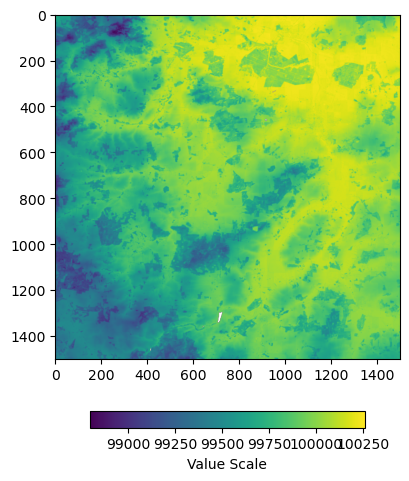

In [12]:
plotter(p)

In [6]:
Tr_K = np.asarray(Tr_K, dtype=np.float32)
(vza,
    T_A_K,
    u,
    ea,
    p,
    Sn_C,
    Sn_S,
    L_dn,
    LAI,
    h_C,
    emis_C,
    emis_S,
    z_0M,
    d_0,
    z_u,
    z_T,
    leaf_width,
    z0_soil,
    alpha_PT,
    x_LAD,
    f_c,
    f_g,
    w_C,
    calcG_array) = map(_check_default_parameter_size,
                    [vza,
                        T_A_K,
                        u,
                        ea,
                        p,
                        Sn_C,
                        Sn_S,
                        L_dn,
                        LAI,
                        h_C,
                        emis_C,
                        emis_S,
                        z_0M,
                        d_0,
                        z_u,
                        z_T,
                        leaf_width,
                        z0_soil,
                        alpha_PT,
                        x_LAD,
                        f_c,
                        f_g,
                        w_C,
                        calcG_params[1]],
                    [Tr_K] * 24)

In [7]:
res_params = resistance_form[1]
resistance_form = resistance_form[0]
# calcG_params[1] = None
# Create the output variables
[Ln_S, Ln_C, H, LE, LE_C, H_C, LE_S, H_S, G, R_S, R_x, R_A, delta_Rn,
    Rn_S, iterations] = [np.zeros(Tr_K.shape, np.float32)+np.nan for i in range(15)]



In [8]:
# iteration of the Monin-Obukhov length
if const_L is None:
    # Initially assume stable atmospheric conditions and set variables for
    L = np.zeros(Tr_K.shape) + np.inf
    max_iterations = ITERATIONS
else:  # We force Monin-Obukhov lenght to the provided array/value
    L = np.ones(Tr_K.shape) * const_L
    max_iterations = 1  # No iteration
# Calculate the general parameters
rho = met.calc_rho(p, ea, T_A_K)  # Air density
c_p = met.calc_c_p(p, ea)  # Heat capacity of air
z_0H = res.calc_z_0H(z_0M, kB=kB)  # Roughness length for heat transport

# Calculate LAI dependent parameters for dataset where LAI > 0
omega0 = CI.calc_omega0_Kustas(LAI, f_c, x_LAD=x_LAD, isLAIeff=True)

In [9]:
F = np.asarray(LAI / f_c, dtype=np.float32)  # Real LAI
# Fraction of vegetation observed by the sensor
f_theta = calc_F_theta_campbell(vza, F, w_C=w_C, Omega0=omega0, x_LAD=x_LAD)
del vza, ea
# Initially assume stable atmospheric conditions and set variables for
# iteration of the Monin-Obukhov length
u_friction = MO.calc_u_star(u, z_u, L, d_0, z_0M)
u_friction = np.asarray(np.maximum(U_FRICTION_MIN, u_friction), dtype=np.float32)
L_queue = deque([np.array(L, np.float32)], 6)
L_converged = np.zeros(Tr_K.shape, bool)
L_diff_max = np.inf

In [10]:
# First assume that canopy temperature equals the minumum of Air or
# radiometric T
T_C = np.asarray(np.minimum(Tr_K, T_A_K), dtype=np.float32)
flag, T_S = calc_T_S(Tr_K, T_C, f_theta)
T_AC = T_A_K.copy()

i = flag != F_INVALID
flag[np.logical_and(~L_converged, flag != F_INVALID)] = F_ALL_FLUXES
LE_S[np.logical_and(~L_converged, flag != F_INVALID)] = -1
alpha_PT_rec = np.asarray(alpha_PT + 0.1, dtype=np.float32)

In [11]:
# Outer loop for estimating stability.
# Stops when difference in consecutives L is below a given threshold
start_time = time.time()
loop_time = time.time()

#for n_iterations in range(max_iterations):

n_iterations = 0
i = flag != F_INVALID
if np.all(L_converged[i]):
    if verbose:
        if L_converged[i].size == 0:
            print("Finished iterations with no valid solution")
        else:
            print(f"Finished interations with a max. L diff: {L_diff_max}")
    # break
    print('break')
current_time = time.time()
loop_duration = current_time - loop_time
loop_time = current_time
total_duration = loop_time - start_time
if verbose:
    print("Iteration: %d, non-converged pixels: %d, max L diff: %f, total time: %f, loop time: %f" %
            (n_iterations, np.sum(~L_converged[i]), L_diff_max, total_duration, loop_duration))
iterations[np.logical_and(~L_converged, flag != F_INVALID)] = n_iterations


# Inner loop to iterativelly reduce alpha_PT in case latent heat flux
# from the soil is negative. The initial assumption is of potential
# canopy transpiration.
flag[np.logical_and(~L_converged, flag != F_INVALID)] = F_ALL_FLUXES
LE_S[np.logical_and(~L_converged, flag != F_INVALID)] = -1
alpha_PT_rec = np.asarray(alpha_PT + 0.1, dtype=np.float32)

# plotter_side_by_side(LE_S, LE_C, ('Latent heat soil', 'Latent heat canopy'))

Iteration: 0, non-converged pixels: 2249441, max L diff: inf, total time: 0.003653, loop time: 0.003632


after calculating soil temperature


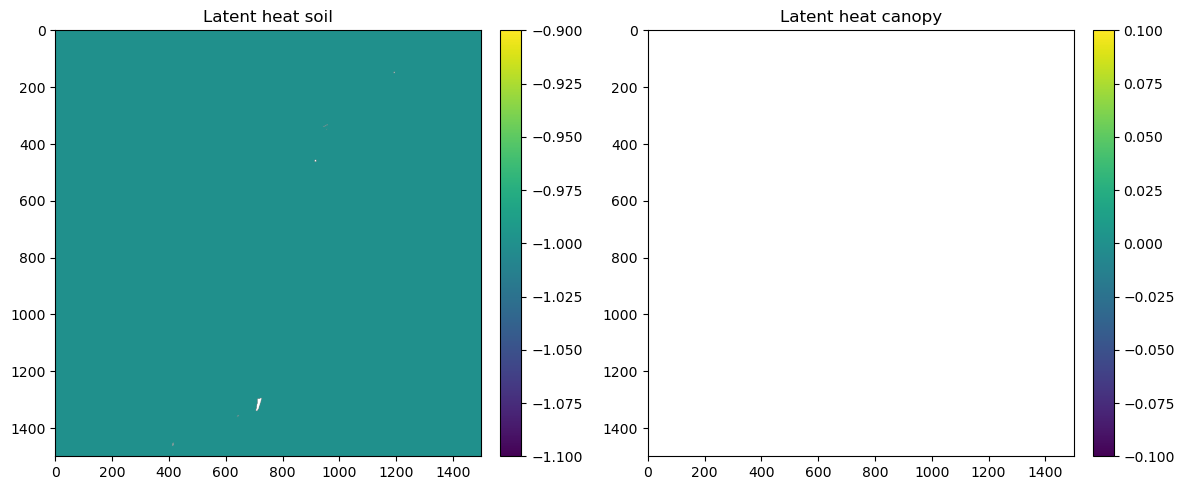

after estimation latent heat fluxes as residual of energy balance at the soil and the canopy


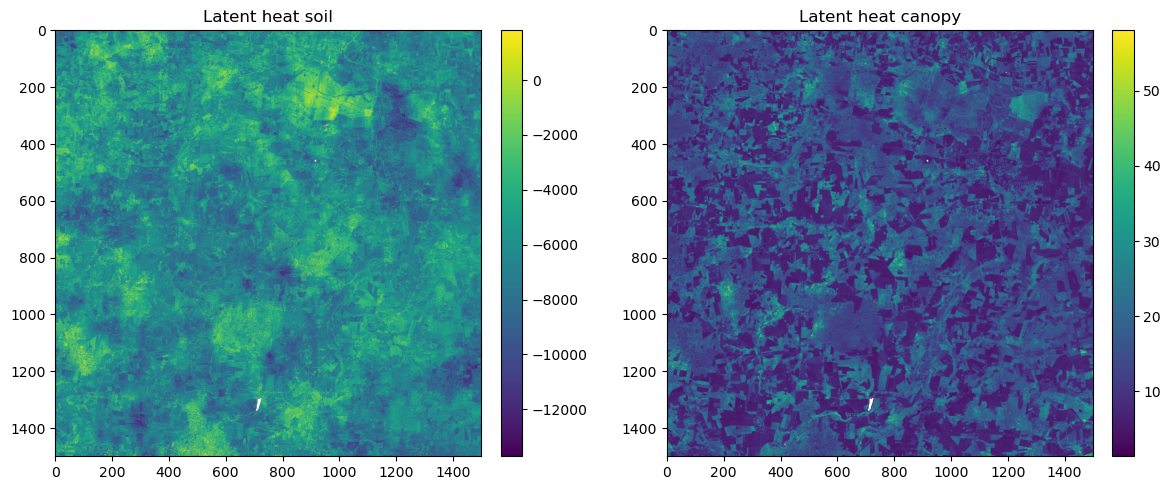

2249441


In [ ]:
while np.any(LE_S[i] < 0):
            
            i = np.logical_and.reduce((LE_S < 0, ~L_converged, flag != F_INVALID))

            alpha_PT_rec[i] -= 0.1

            # There cannot be negative transpiration from the vegetation
            alpha_PT_rec[alpha_PT_rec <= 0.0] = 0.0
            flag[np.logical_and(i, alpha_PT_rec == 0.0)] = F_ZERO_LE

            flag[np.logical_and.reduce((i, alpha_PT_rec < alpha_PT, alpha_PT_rec > 0.0))] =\
                F_ZERO_LE_S

            # Calculate aerodynamic resistances
            R_A[i], R_x[i], R_S[i] = calc_resistances(
                      resistance_form,
                      {"R_A": {"z_T": z_T[i], "u_friction": u_friction[i], "L": L[i],
                               "d_0": d_0[i], "z_0H": z_0H[i]},
                       "R_x": {"u_friction": u_friction[i], "h_C": h_C[i],
                               "d_0": d_0[i],
                               "z_0M": z_0M[i], "L": L[i], "F": F[i], "LAI": LAI[i],
                               "leaf_width": leaf_width[i],
                               "z0_soil": z0_soil[i],
                               "massman_profile": massman_profile,
                               "res_params": {k: res_params[k][i] for k in res_params.keys()}},
                       "R_S": {"u_friction": u_friction[i], "h_C": h_C[i],
                               "d_0": d_0[i],
                               "z_0M": z_0M[i], "L": L[i], "F": F[i], "omega0": omega0[i],
                               "LAI": LAI[i], "leaf_width": leaf_width[i],
                               "z0_soil": z0_soil[i], "z_u": z_u[i],
                               "deltaT": T_S[i] - T_AC[i], 'u': u[i], 'rho': rho[i],
                               "c_p": c_p[i], "f_cover": f_c[i], "w_C": w_C[i],
                               "massman_profile": massman_profile,
                               "res_params": {k: res_params[k][i] for k in res_params.keys()}}
                       }
            )

            # Calculate net longwave radiation with current values of T_C and T_S
            Ln_C[i], Ln_S[i] = rad.calc_L_n_Campbell(
                T_C[i], T_S[i], L_dn[i], LAI[i], emis_C[i], emis_S[i], x_LAD=x_LAD[i])
            delta_Rn[i] = Sn_C[i] + Ln_C[i]
            Rn_S[i] = Sn_S[i] + Ln_S[i]

            # Calculate the canopy and soil temperatures using the Priestley
            # Taylor appoach
            H_C[i] = calc_H_C_PT(
                delta_Rn[i],
                f_g[i],
                T_A_K[i],
                p[i],
                c_p[i],
                alpha_PT_rec[i])
            T_C[i] = calc_T_C_series(Tr_K[i], T_A_K[i], R_A[i], R_x[i], R_S[i],
                                     f_theta[i], H_C[i], rho[i], c_p[i])

            # Calculate soil temperature
            flag_t = np.zeros(flag.shape) + F_ALL_FLUXES
            flag_t[i], T_S[i] = calc_T_S(Tr_K[i], T_C[i], f_theta[i])
            flag[flag_t == F_INVALID] = F_INVALID
            LE_S[flag_t == F_INVALID] = 0
            

            # LE_S1 = LE_S.copy()
            # LE_C1 = LE_C.copy()
            print('after calculating soil temperature')
            plotter_side_by_side(LE_S, LE_C, ('Latent heat soil', 'Latent heat canopy'))


            
            # Recalculate soil resistance using new soil temperature
            _, _, R_S[i] = calc_resistances(
                    resistance_form,
                    {"R_S": {"u_friction": u_friction[i], "h_C": h_C[i], "d_0": d_0[i],
                             "z_0M": z_0M[i], "L": L[i], "F": F[i], "omega0": omega0[i],
                             "LAI": LAI[i], "leaf_width": leaf_width[i],
                             "z0_soil": z0_soil[i],  "z_u": z_u[i],
                             "deltaT": T_S[i] - T_AC[i], "u": u[i], "rho": rho[i],
                             "c_p": c_p[i], "f_cover": f_c[i], "w_C": w_C[i],
                             "massman_profile": massman_profile,
                             "res_params": {k: res_params[k][i] for k in res_params.keys()}}
                     }
            )

            i = np.logical_and.reduce((LE_S < 0, ~L_converged, flag != F_INVALID))

            # Get air temperature at canopy interface
            T_AC[i] = ((T_A_K[i] / R_A[i] + T_S[i] / R_S[i] + T_C[i] / R_x[i])
                       / (1.0 / R_A[i] + 1.0 / R_S[i] + 1.0 / R_x[i]))

            # Calculate soil fluxes
            H_S[i] = rho[i] * c_p[i] * (T_S[i] - T_AC[i]) / R_S[i]

            # Compute Soil Heat Flux Ratio
            G[i] = calc_G([calcG_params[0], calcG_array], Rn_S, i)

            # Estimate latent heat fluxes as residual of energy balance at the
            # soil and the canopy
            LE_S[i] = Rn_S[i] - G[i] - H_S[i]
            LE_C[i] = delta_Rn[i] - H_C[i]


            # LE_S2 = LE_S.copy()
            # LE_C2 = LE_C.copy()

            # print('difference between after calculation soil temp and estimation of latent heat fluxes as residual of energy balance at the soil and the canopy')
            # LE_S3 = LE_S1 - LE_S2
            # LE_C3 = LE_C1 - LE_C2
            # plotter_side_by_side(LE_S3, LE_C3, ('Latent heat soil', 'Latent heat canopy'))

            print('after estimation latent heat fluxes as residual of energy balance at the soil and the canopy')
            plotter_side_by_side(LE_S, LE_C, ('Latent heat soil', 'Latent heat canopy'))
            
            
        
            # Special case if there is no transpiration from vegetation.
            # In that case, there should also be no evaporation from the soil
            # and the energy at the soil should be conserved.
            # See end of appendix A1 in Guzinski et al. (2015).
            noT = np.logical_and(i, LE_C == 0)
            H_S[noT] = np.minimum(H_S[noT], Rn_S[noT] - G[noT])
            G[noT] = np.maximum(G[noT], Rn_S[noT] - H_S[noT])
            LE_S[noT] = 0

            # Calculate total fluxes
            H[i] = np.asarray(H_C[i] + H_S[i], dtype=np.float32)
            LE[i] = np.asarray(LE_C[i] + LE_S[i], dtype=np.float32)
            # Now L can be recalculated and the difference between iterations
            # derived
            if const_L is None:
                L[i] = MO.calc_L(
                    u_friction[i],
                    T_A_K[i],
                    rho[i],
                    c_p[i],
                    H[i],
                    LE[i])
                # Calculate again the friction velocity with the new stability
                # correctios
                u_friction[i] = MO.calc_u_star(
                    u[i], z_u[i], L[i], d_0[i], z_0M[i])
                u_friction[i] = np.asarray(np.maximum(U_FRICTION_MIN, u_friction[i]), dtype=np.float32)

                print(len(LE_S[i]<0))

In [ ]:
i = np.logical_and.reduce((LE_S < 0, ~L_converged, flag != F_INVALID))

alpha_PT_rec[i] -= 0.1

# There cannot be negative transpiration from the vegetation
alpha_PT_rec[alpha_PT_rec <= 0.0] = 0.0
flag[np.logical_and(i, alpha_PT_rec == 0.0)] = F_ZERO_LE

flag[np.logical_and.reduce((i, alpha_PT_rec < alpha_PT, alpha_PT_rec > 0.0))] =\
    F_ZERO_LE_S

# Calculate aerodynamic resistances
R_A[i], R_x[i], R_S[i] = calc_resistances(
            resistance_form,
            {"R_A": {"z_T": z_T[i], "u_friction": u_friction[i], "L": L[i],
                    "d_0": d_0[i], "z_0H": z_0H[i]},
            "R_x": {"u_friction": u_friction[i], "h_C": h_C[i],
                    "d_0": d_0[i],
                    "z_0M": z_0M[i], "L": L[i], "F": F[i], "LAI": LAI[i],
                    "leaf_width": leaf_width[i],
                    "z0_soil": z0_soil[i],
                    "massman_profile": massman_profile,
                    "res_params": {k: res_params[k][i] for k in res_params.keys()}},
            "R_S": {"u_friction": u_friction[i], "h_C": h_C[i],
                    "d_0": d_0[i],
                    "z_0M": z_0M[i], "L": L[i], "F": F[i], "omega0": omega0[i],
                    "LAI": LAI[i], "leaf_width": leaf_width[i],
                    "z0_soil": z0_soil[i], "z_u": z_u[i],
                    "deltaT": T_S[i] - T_AC[i], 'u': u[i], 'rho': rho[i],
                    "c_p": c_p[i], "f_cover": f_c[i], "w_C": w_C[i],
                    "massman_profile": massman_profile,
                    "res_params": {k: res_params[k][i] for k in res_params.keys()}}
            }
)

# Calculate net longwave radiation with current values of T_C and T_S
Ln_C[i], Ln_S[i] = rad.calc_L_n_Campbell(
    T_C[i], T_S[i], L_dn[i], LAI[i], emis_C[i], emis_S[i], x_LAD=x_LAD[i])
delta_Rn[i] = Sn_C[i] + Ln_C[i]
Rn_S[i] = Sn_S[i] + Ln_S[i]

In [ ]:
# Calculate the canopy and soil temperatures using the Priestley
# Taylor appoach
H_C[i] = calc_H_C_PT(
    delta_Rn[i],
    f_g[i],
    T_A_K[i],
    p[i],
    c_p[i],
    alpha_PT_rec[i])
T_C[i] = calc_T_C_series(Tr_K[i], T_A_K[i], R_A[i], R_x[i], R_S[i],
                            f_theta[i], H_C[i], rho[i], c_p[i])

# Calculate soil temperature
flag_t = np.zeros(flag.shape) + F_ALL_FLUXES
flag_t[i], T_S[i] = calc_T_S(Tr_K[i], T_C[i], f_theta[i])
flag[flag_t == F_INVALID] = F_INVALID
LE_S[flag_t == F_INVALID] = 0


# LE_S1 = LE_S.copy()
# LE_C1 = LE_C.copy()
print('after calculating soil temperature')
plotter_side_by_side(LE_S, LE_C, ('Latent heat soil', 'Latent heat canopy'))



# Recalculate soil resistance using new soil temperature
_, _, R_S[i] = calc_resistances(
        resistance_form,
        {"R_S": {"u_friction": u_friction[i], "h_C": h_C[i], "d_0": d_0[i],
                    "z_0M": z_0M[i], "L": L[i], "F": F[i], "omega0": omega0[i],
                    "LAI": LAI[i], "leaf_width": leaf_width[i],
                    "z0_soil": z0_soil[i],  "z_u": z_u[i],
                    "deltaT": T_S[i] - T_AC[i], "u": u[i], "rho": rho[i],
                    "c_p": c_p[i], "f_cover": f_c[i], "w_C": w_C[i],
                    "massman_profile": massman_profile,
                    "res_params": {k: res_params[k][i] for k in res_params.keys()}}
            }
)

i = np.logical_and.reduce((LE_S < 0, ~L_converged, flag != F_INVALID))

# Get air temperature at canopy interface
T_AC[i] = ((T_A_K[i] / R_A[i] + T_S[i] / R_S[i] + T_C[i] / R_x[i])
            / (1.0 / R_A[i] + 1.0 / R_S[i] + 1.0 / R_x[i]))

# Calculate soil fluxes
H_S[i] = rho[i] * c_p[i] * (T_S[i] - T_AC[i]) / R_S[i]

# Compute Soil Heat Flux Ratio
G[i] = calc_G([calcG_params[0], calcG_array], Rn_S, i)

# Estimate latent heat fluxes as residual of energy balance at the
# soil and the canopy
LE_S[i] = Rn_S[i] - G[i] - H_S[i]
LE_C[i] = delta_Rn[i] - H_C[i]


# LE_S2 = LE_S.copy()
# LE_C2 = LE_C.copy()

# print('difference between after calculation soil temp and estimation of latent heat fluxes as residual of energy balance at the soil and the canopy')
# LE_S3 = LE_S1 - LE_S2
# LE_C3 = LE_S2 - LE_C2
# plotter_side_by_side(LE_S3, LE_C3, ('Latent heat soil', 'Latent heat canopy'))

print('after estimation latent heat fluxes as residual of energy balance at the soil and the canopy')
plotter_side_by_side(LE_S, LE_C, ('Latent heat soil', 'Latent heat canopy'))



# Special case if there is no transpiration from vegetation.
# In that case, there should also be no evaporation from the soil
# and the energy at the soil should be conserved.
# See end of appendix A1 in Guzinski et al. (2015).
noT = np.logical_and(i, LE_C == 0)
H_S[noT] = np.minimum(H_S[noT], Rn_S[noT] - G[noT])
G[noT] = np.maximum(G[noT], Rn_S[noT] - H_S[noT])
LE_S[noT] = 0

# Calculate total fluxes
H[i] = np.asarray(H_C[i] + H_S[i], dtype=np.float32)
LE[i] = np.asarray(LE_C[i] + LE_S[i], dtype=np.float32)
# Now L can be recalculated and the difference between iterations
# derived
if const_L is None:
    L[i] = MO.calc_L(
        u_friction[i],
        T_A_K[i],
        rho[i],
        c_p[i],
        H[i],
        LE[i])
    # Calculate again the friction velocity with the new stability
    # correctios
    u_friction[i] = MO.calc_u_star(
        u[i], z_u[i], L[i], d_0[i], z_0M[i])
    u_friction[i] = np.asarray(np.maximum(U_FRICTION_MIN, u_friction[i]), dtype=np.float32)

    print(len(LE_S[i]<0))

In [ ]:
if const_L is None:
    # We check convergence against the value of L from previous iteration but as well
    # against values from 2 or 3 iterations back. This is to catch situations (not
    # infrequent) where L oscillates between 2 or 3 steady state values.
    i, L_queue, L_converged, L_diff_max = monin_obukhov_convergence(L,
                                                                    L_queue,
                                                                    L_converged,
                                                                    flag)

In [ ]:
(flag,
    T_S,
    T_C,
    T_AC,
    L_nS,
    L_nC,
    LE_C,
    H_C,
    LE_S,
    H_S,
    G,
    R_S,
    R_x,
    R_A,
    u_friction,
    L,
    n_iterations) = map(np.asarray,
                        (flag,
                        T_S,
                        T_C,
                        T_AC,
                        Ln_S,
                        Ln_C,
                        LE_C, # this one
                        H_C,
                        LE_S, # this probably also
                        H_S,
                        G,
                        R_S,
                        R_x,
                        R_A,
                        u_friction,
                        L,
                        iterations))

# return (flag, T_S, T_C, T_AC, L_nS, L_nC, LE_C, H_C, LE_S, H_S, G, R_S, R_x, R_A, u_friction,
#         L, n_iterations)